# F55 Rayleigh Fractionation
### Jan Kesting, Felix Fleischle
### 9.1. - 11.1.2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
from scipy.optimize import curve_fit
dirname = os.path.dirname("__file__")

# 6.2 Observing Rayleigh Fractionation

In [2]:
fileloc_rayleigh = os.path.join(dirname, 'twvia_2023-01-08_f0000.txt')

time = np.loadtxt(fileloc_rayleigh, dtype = "str", skiprows = 7844, usecols = (0), delimiter = ",", unpack=True, max_rows = 221)
H2O_ppm, H2O_ppm_sd, O18_del, O18_del_sd, D_del, D_del_sd, O17_del, O17_del_sd=np.loadtxt(fileloc_rayleigh,skiprows = 7844, usecols = (1,2,3,4,5,6,7,8), delimiter = ",", unpack=True, max_rows = 221)

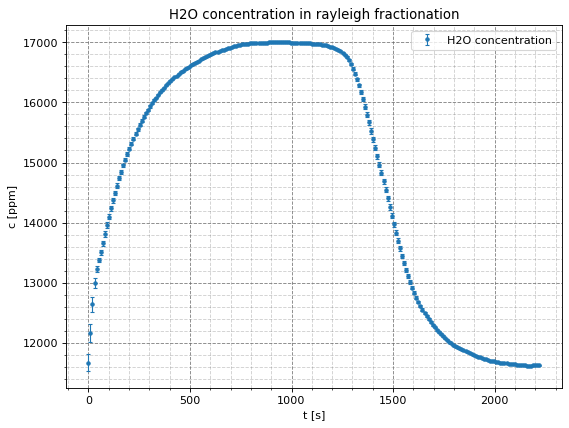

In [3]:
# Defining x axis by calculating delta_t from the beginning of the measurement
t_start = 42960 # seconds, corresponds to 11:56
t_end = 45180 # seconds, corresponds to 12:33
delta_t = t_end - t_start
x = np.linspace(0, delta_t, 221)

# Plotting the H2O concentration over time
plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(x,H2O_ppm, yerr = H2O_ppm_sd, linestyle='None', marker = ".", label="H2O concentration", capsize = 2, elinewidth=1)
plt.xlabel('t [s]')
plt.ylabel('c [ppm]')
plt.title('H2O concentration in rayleigh fractionation')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

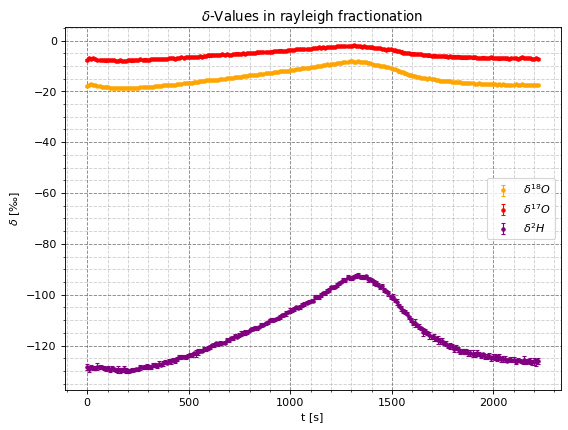

In [4]:
# Now plotting the delta values over time
plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(x,O18_del, yerr = O18_del_sd, linestyle='None', marker = ".", color = "orange", label="$\delta^{18}O$", capsize = 2, elinewidth=1)
plt.errorbar(x,O17_del, yerr = O17_del_sd, linestyle='None', marker = ".", color = "red", label="$\delta^{17}O$", capsize = 2, elinewidth=1)
plt.errorbar(x,D_del, yerr = D_del_sd, linestyle='None', marker = ".", color = "purple", label="$\delta^{2}H$", capsize = 2, elinewidth=1)
plt.xlabel('t [s]')
plt.ylabel('$\delta$ [‰]')
plt.title('$\delta$-Values in rayleigh fractionation')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

We can observe that after inserting the water drop into the TIWA, all three delta values decrease by a small amount. The reason for this slight decrease is that when the drop is first inserted and begins to evaporate, the first water vapor measured contains the least heavy isotopes.
After some time, the water vapor gets heavier and heavier, due to the drop consisting of water with a higher and higher abundance of heavy isotopes.
After the maximum is reached, the drop is fully evaporated and the delta values are decreasing to normal ambient air values again.

# Data extraction for 6.1, 6.3 and 6.4
This part only contains the extraction of the relevant data from the files.
Our code is filled with redundancies, but it works :)

In [5]:
# Begin with extracting and analyzing the temperature and humidity data
fileloc_testo = os.path.join(dirname, 'Testo Data day 1 and half day 2.txt')

testo_id, testo_T, testo_relhum = np.loadtxt(fileloc_testo, skiprows = 1, usecols = (0, 4, 5), unpack=True, max_rows = 323)

In [6]:
# Calculate mean Temperature and mean relative Humidity
testo_T_mean = np.mean(testo_T)
testo_T_mean_sd = np.std(testo_T)

testo_relhum_mean = np.mean(testo_relhum)
testo_relhum_mean_sd = np.std(testo_relhum)

print("Mean Temperature: T = " , testo_T_mean , "+-" , testo_T_mean_sd , " [°C]")
print("Mean relative Humidity: h = " , testo_relhum_mean , "+-" , testo_relhum_mean_sd , " [%]")

Mean Temperature: T =  23.153560371517028 +- 0.7224901159998725  [°C]
Mean relative Humidity: h =  36.88606811145511 +- 1.7699480555089289  [%]


In [7]:
# Extract the water temperature, rainwater samples and unknown samples data from the text files
fileloc_w1 = os.path.join(dirname, 'tlwia2022-11-21_f0002-Processed.txt')

sample_name = np.loadtxt(fileloc_w1, skiprows=1, usecols=(0), dtype = "str", unpack=True, max_rows=70)
H2O, delta_2H, delta_2H_sd, delta_18O, delta_18O_sd, delta_17O, delta_17O_sd = np.loadtxt(fileloc_w1, skiprows=1, usecols=(1,2,3,4,5,6,7), unpack=True, max_rows=70)

fileloc_w2 = os.path.join(dirname, 'tlwia2022-11-22_f0001-Processed.txt')

sample_name_w2 = np.loadtxt(fileloc_w2, skiprows=1, usecols=(0), dtype = "str", unpack=True, max_rows=79)
H2O_w2, delta_2H_w2, delta_2H_sd_w2, delta_18O_w2, delta_18O_sd_w2, delta_17O_w2, delta_17O_sd_w2 = np.loadtxt(fileloc_w2, skiprows=1, usecols=(1,2,3,4,5,6,7), unpack=True, max_rows=79)
unknown_samples_list = np.array(["W017", "W070", "W071", "K001", "K007"])
rainwater_samples_list = np.array(["603", "641", "102", "105"])

In [8]:
# Now create arrays for the 40 and 50 degree water data
# First, we are creating 2d arrays, since we have a different number of values to take the mean of for each sample, we need to count the amount of values for each sample
# Later, the means will be saved in the 1d arrays below
water_40_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_H2O = np.array([0,0,0,0,0,0,0], np.float64)
water_50_H2O = np.array([0,0,0,0,0,0,0], np.float64)

# Iterate over all datapoints
for i in range(sample_name.size):
    # Choose all samples containing the number 40 or 50, to select those measurements relevant to this part of the experiment
    if ("40;" in sample_name[i]):
        # Extract the id of the measurement from the name of the measurement, i.e. "40;1", "40;2" etc.
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        # print("Sample ID:", sample_id_int + 1)
        # Make sure the value is not NaN
        if (math.isnan(H2O[i]) == False):
            # add the value to the array, and save the amount of values we have for this sample in the 2nd dimension of the array
            water_40_H2O_2d[sample_id_int,0] += H2O[i]
            water_40_H2O_2d[sample_id_int,1] += float(1)
            #print("Adding H2O value of ", H2O[i])
            
    # Equivalent for 50°C
    if ("50;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        print("Sample ID:", sample_id_int + 1)
        if (math.isnan(H2O[i]) == False):
            water_50_H2O_2d[sample_id_int,0] += H2O[i]
            water_50_H2O_2d[sample_id_int,1] += float(1)
            
# Now take the means of all entries by dividing by the number stored in the 2nd array dimension
for i in range(water_40_H2O.size):
    if (water_40_H2O_2d[i,1]!=0):
        water_40_H2O[i] = water_40_H2O_2d[i,0]/water_40_H2O_2d[i,1]
    else:
        water_40_H2O[i] = float("nan")
    if (water_50_H2O_2d[i,1]!=0):
        water_50_H2O[i] = water_50_H2O_2d[i,0]/water_50_H2O_2d[i,1]
    else:
        water_50_H2O[i] = float("nan")
print(water_40_H2O)
print(water_50_H2O)

Sample ID: 1
Sample ID: 2
Sample ID: 3
Sample ID: 4
Sample ID: 4
Sample ID: 5
Sample ID: 6
Sample ID: 7
Sample ID: 7
Sample ID: 6
Sample ID: 5
Sample ID: 4
Sample ID: 3
Sample ID: 2
Sample ID: 2
Sample ID: 1
[2.991402e+16 2.920270e+16 2.927615e+16 2.922762e+16 2.971881e+16
 2.935460e+16 2.947921e+16]
[2.9315335e+16 2.9176575e+16 2.9445270e+16 2.9247850e+16 2.9016170e+16
 2.9131000e+16 2.9283575e+16]


In [9]:
# Do the same for delta D values
# Same principle as above for all values from now on
# Here we also extract the errors of each value, which has to be quadratically added
water_40_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_2H = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_2H = np.array([0,0,0,0,0,0,0], np.float64)
water_40_delta_2H_sd = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_2H_sd = np.array([0,0,0,0,0,0,0], np.float64)
for i in range(sample_name.size):
    if ("40;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        #print("Sample ID:", sample_id_int + 1)
        if ((math.isnan(delta_2H[i]) == False) and (math.isnan(delta_2H_sd[i]) == False)):
            water_40_delta_2H_2d[sample_id_int,0] += delta_2H[i]
            water_40_delta_2H_2d[sample_id_int,1] += float(1)
            
            water_40_delta_2H_sd_2d[sample_id_int,0] += delta_2H_sd[i]**2
            water_40_delta_2H_sd_2d[sample_id_int,1] += float(1)
            
    if ("50;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        if ((math.isnan(delta_2H[i]) == False) and (math.isnan(delta_2H_sd[i]) == False)):
            water_50_delta_2H_2d[sample_id_int,0] += delta_2H[i]
            water_50_delta_2H_2d[sample_id_int,1] += float(1)
            
            water_50_delta_2H_sd_2d[sample_id_int,0] += delta_2H_sd[i]**2
            water_50_delta_2H_sd_2d[sample_id_int,1] += float(1)
            
for i in range(water_40_delta_2H.size):
    if (water_40_delta_2H_2d[i,1]!=0):
        water_40_delta_2H[i] = water_40_delta_2H_2d[i,0]/water_40_delta_2H_2d[i,1]
    else:
        water_40_delta_2H[i] = float("nan")
    
    if (water_40_delta_2H_sd_2d[i,1]!=0):
        water_40_delta_2H_sd[i] = np.sqrt(water_40_delta_2H_sd_2d[i,0])/water_40_delta_2H_sd_2d[i,1]
    else:
        water_40_delta_2H_sd[i] = float("nan")
    
    if (water_50_delta_2H_2d[i,1]!=0):
        water_50_delta_2H[i] = water_50_delta_2H_2d[i,0]/water_50_delta_2H_2d[i,1]
    else:
        water_50_delta_2H[i] = float("nan")
        
    if (water_50_delta_2H_sd_2d[i,1]!=0):
        water_50_delta_2H_sd[i] = np.sqrt(water_50_delta_2H_sd_2d[i,0])/water_50_delta_2H_sd_2d[i,1]
    else:
        water_50_delta_2H_sd[i] = float("nan")

print(water_40_delta_2H)
print(water_40_delta_2H_sd)
print(water_50_delta_2H)
print(water_50_delta_2H_sd)

[-59.557547  -57.545005  -56.678436  -55.556478  -54.207502  -53.1291515
 -51.5028095]
[0.7929829  0.3874424  0.6098075  0.3140557  0.23587989 0.40872544
 0.34576367]
[-59.051559  -57.1658525 -54.634541  -51.7012825 -49.352494  -46.160142
 -42.982619 ]
[0.34728575 0.361381   0.6266324  0.3420542  0.5180777  0.1637768
 0.43992797]


In [10]:
# Do the same for delta 18O values
water_40_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_18O = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_18O = np.array([0,0,0,0,0,0,0], np.float64)
water_40_delta_18O_sd = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_18O_sd = np.array([0,0,0,0,0,0,0], np.float64)
for i in range(sample_name.size):
    if ("40;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        #print("Sample ID:", sample_id_int + 1)
        if ((math.isnan(delta_18O[i]) == False) and (math.isnan(delta_18O_sd[i]) == False)):
            water_40_delta_18O_2d[sample_id_int,0] += delta_18O[i]
            water_40_delta_18O_2d[sample_id_int,1] += float(1)
            #print("Adding the following O18 value: ", delta_18O[i])
            
            water_40_delta_18O_sd_2d[sample_id_int,0] += delta_18O_sd[i]**2
            water_40_delta_18O_sd_2d[sample_id_int,1] += float(1)
            
    if ("50;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        if ((math.isnan(delta_18O[i]) == False) and (math.isnan(delta_18O_sd[i]) == False)):
            water_50_delta_18O_2d[sample_id_int,0] += delta_18O[i]
            water_50_delta_18O_2d[sample_id_int,1] += float(1)
            
            water_50_delta_18O_sd_2d[sample_id_int,0] += delta_18O_sd[i]**2
            water_50_delta_18O_sd_2d[sample_id_int,1] += float(1)
            
for i in range(water_40_delta_18O.size):
    if (water_40_delta_18O_2d[i,1]!=0):
        water_40_delta_18O[i] = water_40_delta_18O_2d[i,0]/water_40_delta_18O_2d[i,1]
    else:
        water_40_delta_18O[i] = float("nan")
    
    if (water_40_delta_18O_sd_2d[i,1]!=0):
        water_40_delta_18O_sd[i] = np.sqrt(water_40_delta_18O_sd_2d[i,0])/water_40_delta_18O_sd_2d[i,1]
    else:
        water_40_delta_18O_sd[i] = float("nan")
    
    if (water_50_delta_18O_2d[i,1]!=0):
        water_50_delta_18O[i] = water_50_delta_18O_2d[i,0]/water_50_delta_18O_2d[i,1]
    else:
        water_50_delta_18O[i] = float("nan")
        
    if (water_50_delta_18O_sd_2d[i,1]!=0):
        water_50_delta_18O_sd[i] = np.sqrt(water_50_delta_18O_sd_2d[i,0])/water_50_delta_18O_sd_2d[i,1]
    else:
        water_50_delta_18O_sd[i] = float("nan")

print(water_40_delta_18O)
print(water_40_delta_18O_sd)
print(water_50_delta_18O)
print(water_50_delta_18O_sd)

[-8.331498 -7.592628 -7.359676 -7.358254 -6.763276 -6.64033  -6.226453]
[0.1630297  0.1090298  0.09624214 0.0463301  0.02878096 0.07427974
 0.05249103]
[-8.260712  -7.6875415 -6.846214  -5.9202935 -5.069174  -4.105485
 -3.179445 ]
[0.00821171 0.07354588 0.0671811  0.04849823 0.07198428 0.03253514
 0.0539773 ]


In [11]:
# Do the same for delta 17O values
water_40_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_50_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_40_delta_17O = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_17O = np.array([0,0,0,0,0,0,0], np.float64)
water_40_delta_17O_sd = np.array([0,0,0,0,0,0,0], np.float64)
water_50_delta_17O_sd = np.array([0,0,0,0,0,0,0], np.float64)
for i in range(sample_name.size):
    if ("40;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        #print("Sample ID:", sample_id_int + 1)
        if ((math.isnan(delta_17O[i]) == False) and (math.isnan(delta_17O_sd[i]) == False)):
            water_40_delta_17O_2d[sample_id_int,0] += delta_17O[i]
            water_40_delta_17O_2d[sample_id_int,1] += float(1)
            print("Adding the following O17 value: ", delta_17O[i])
            
            water_40_delta_17O_sd_2d[sample_id_int,0] += delta_17O_sd[i]**2
            water_40_delta_17O_sd_2d[sample_id_int,1] += float(1)
            
    if ("50;" in sample_name[i]):
        sample_id = sample_name[i][3:]
        sample_id_int = int(sample_id) - 1
        if ((math.isnan(delta_17O[i]) == False) and (math.isnan(delta_17O_sd[i]) == False)):
            water_50_delta_17O_2d[sample_id_int,0] += delta_17O[i]
            water_50_delta_17O_2d[sample_id_int,1] += float(1)
            
            water_50_delta_17O_sd_2d[sample_id_int,0] += delta_17O_sd[i]**2
            water_50_delta_17O_sd_2d[sample_id_int,1] += float(1)
            
for i in range(water_40_delta_17O.size):
    if (water_40_delta_17O_2d[i,1]!=0):
        water_40_delta_17O[i] = water_40_delta_17O_2d[i,0]/water_40_delta_17O_2d[i,1]
    else:
        water_40_delta_17O[i] = float("nan")
    
    if (water_40_delta_17O_sd_2d[i,1]!=0):
        water_40_delta_17O_sd[i] = np.sqrt(water_40_delta_17O_sd_2d[i,0])/water_40_delta_17O_sd_2d[i,1]
    else:
        water_40_delta_17O_sd[i] = float("nan")
    
    if (water_50_delta_17O_2d[i,1]!=0):
        water_50_delta_17O[i] = water_50_delta_17O_2d[i,0]/water_50_delta_17O_2d[i,1]
    else:
        water_50_delta_17O[i] = float("nan")
        
    if (water_50_delta_17O_sd_2d[i,1]!=0):
        water_50_delta_17O_sd[i] = np.sqrt(water_50_delta_17O_sd_2d[i,0])/water_50_delta_17O_sd_2d[i,1]
    else:
        water_50_delta_17O_sd[i] = float("nan")

print(water_40_delta_17O)
print(water_40_delta_17O_sd)
print(water_50_delta_17O)
print(water_50_delta_17O_sd)

Adding the following O17 value:  -4.290802
Adding the following O17 value:  -4.089569
Adding the following O17 value:  -3.628229
Adding the following O17 value:  -3.784332
Adding the following O17 value:  -3.632487
Adding the following O17 value:  -2.915681
Adding the following O17 value:  -3.182254
Adding the following O17 value:  -3.33672
Adding the following O17 value:  -3.574638
Adding the following O17 value:  -4.223756
[-4.223756  -4.290802  -4.089569  -3.574638  -3.4824745 -3.483293
 -3.274084 ]
[0.09018477 0.03196726 0.126879   0.07444796 0.03291298 0.01800505
 0.03204043]
[-4.3073865 -4.0667335 -3.563346  -3.056008  -2.781222  -2.215443
 -1.7271535]
[0.04816567 0.04744622 0.05332622 0.04558966 0.02283007 0.00693411
 0.03898763]


In [12]:
# Now create arrays for the 60 degree water data, as well as for the samples
water_60_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_H2O = np.array([0,0,0,0,0,0,0], np.float64)
rainwater_samples_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_H2O = np.array([0,0,0,0], np.float64)

unknown_samples_H2O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_H2O = np.array([0,0,0,0,0], np.float64)



for i in range(sample_name_w2.size):
    if ("60;" in sample_name_w2[i]):
        sample_id_w2 = sample_name_w2[i][3:]
        sample_id_int_w2 = int(sample_id_w2) - 1
        # print("Sample ID:", sample_id_int_w2 + 1)
        if (math.isnan(H2O_w2[i]) == False):
            water_60_H2O_2d[sample_id_int_w2,0] += H2O_w2[i]
            water_60_H2O_2d[sample_id_int_w2,1] += float(1)
            print("Adding H2O value of ", H2O_w2[i], "to 60deg data at", sample_id_int_w2)
        
    rainwater_sample_id = -1
    if (sample_name_w2[i] in rainwater_samples_list):
        rainwater_sample_id = np.where(rainwater_samples_list == sample_name_w2[i])

    if (math.isnan(H2O_w2[i]) == False and rainwater_sample_id != -1):
        rainwater_samples_H2O_2d[rainwater_sample_id, 0] += H2O_w2[i]
        rainwater_samples_H2O_2d[rainwater_sample_id, 1] += float(1)
        print("Adding H2O value of ", H2O_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        
    unknown_sample_id = -1
    if (sample_name_w2[i] in unknown_samples_list):
        unknown_sample_id = np.where(unknown_samples_list == sample_name_w2[i])
        
    if (math.isnan(H2O_w2[i]) == False and unknown_sample_id != -1):
        unknown_samples_H2O_2d[unknown_sample_id, 0] += H2O_w2[i]
        unknown_samples_H2O_2d[unknown_sample_id, 1] += float(1)
        print("Adding H2O value of ", H2O_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
            
    
            
for i in range(water_60_H2O.size):
    if (water_60_H2O_2d[i,1]!=0):
        water_60_H2O[i] = water_60_H2O_2d[i,0]/water_60_H2O_2d[i,1]
    else:
        water_60_H2O[i] = float("nan")
        
for i in range(rainwater_samples_H2O.size):
    if (rainwater_samples_H2O_2d[i,1]!=0):
        rainwater_samples_H2O[i] = rainwater_samples_H2O_2d[i,0]/rainwater_samples_H2O_2d[i,1]
    else:
        rainwater_samples_H2O[i] = float("nan")
        
for i in range(unknown_samples_H2O.size):
    if (unknown_samples_H2O_2d[i,1]!=0):
        unknown_samples_H2O[i] = unknown_samples_H2O_2d[i,0]/unknown_samples_H2O_2d[i,1]
    else:
        unknown_samples_H2O[i] = float("nan")

print(water_60_H2O)
print(rainwater_samples_H2O)
print(unknown_samples_H2O)

Adding H2O value of  2.889455e+16 to 60deg data at 0
Adding H2O value of  2.864602e+16 to 60deg data at 3
Adding H2O value of  2.90598e+16 to 60deg data at 5
Adding H2O value of  2.896585e+16 to 60deg data at 6
Adding H2O value of  2.905527e+16 to rainwater samples data for sample ['105']
Adding H2O value of  2.898947e+16 to unknown samples data for sample ['W017']
Adding H2O value of  2.914675e+16 to unknown samples data for sample ['W071']
Adding H2O value of  2.896132e+16 to unknown samples data for sample ['K001']
Adding H2O value of  2.90831e+16 to unknown samples data for sample ['K007']
Adding H2O value of  2.898075e+16 to unknown samples data for sample ['K001']
Adding H2O value of  2.898992e+16 to unknown samples data for sample ['W071']
Adding H2O value of  2.902512e+16 to unknown samples data for sample ['W070']
Adding H2O value of  2.89847e+16 to unknown samples data for sample ['W017']
Adding H2O value of  2.906122e+16 to rainwater samples data for sample ['105']
Adding H2

In [13]:
# Equivalent for delta D
water_60_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_2H = np.array([0,0,0,0,0,0,0], np.float64)
water_60_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_2H_sd = np.array([0,0,0,0,0,0,0], np.float64)

rainwater_samples_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_2H = np.array([0,0,0,0], np.float64)
rainwater_samples_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_2H_sd = np.array([0,0,0,0], np.float64)

unknown_samples_delta_2H_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_2H = np.array([0,0,0,0,0], np.float64)
unknown_samples_delta_2H_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_2H_sd = np.array([0,0,0,0,0], np.float64)



for i in range(sample_name_w2.size):
    if ("60;" in sample_name_w2[i]):
        sample_id_w2 = sample_name_w2[i][3:]
        sample_id_int_w2 = int(sample_id_w2) - 1
        # print("Sample ID:", sample_id_int_w2 + 1)
        if (math.isnan(delta_2H_w2[i]) == False and math.isnan(delta_2H_sd_w2[i]) == False):
            water_60_delta_2H_2d[sample_id_int_w2,0] += delta_2H_w2[i]
            water_60_delta_2H_2d[sample_id_int_w2,1] += float(1)
            
            water_60_delta_2H_sd_2d[sample_id_int_w2,0] += delta_2H_sd_w2[i]**2
            water_60_delta_2H_sd_2d[sample_id_int_w2,1] += float(1)
            print("Adding delta 2H value of ", delta_2H_w2[i], "to 60deg data at", sample_id_int_w2)
            print("Adding delta 2H sd value of ", delta_2H_sd_w2[i], "to 60deg data at", sample_id_int_w2)
        
    rainwater_sample_id = -1
    if (sample_name_w2[i] in rainwater_samples_list):
        rainwater_sample_id = np.where(rainwater_samples_list == sample_name_w2[i])

    if (math.isnan(delta_2H_w2[i]) == False and math.isnan(delta_2H_sd_w2[i]) == False and rainwater_sample_id != -1):
        rainwater_samples_delta_2H_2d[rainwater_sample_id, 0] += delta_2H_w2[i]
        rainwater_samples_delta_2H_2d[rainwater_sample_id, 1] += float(1)
        
        rainwater_samples_delta_2H_sd_2d[rainwater_sample_id, 0] += delta_2H_sd_w2[i]**2
        rainwater_samples_delta_2H_sd_2d[rainwater_sample_id, 1] += float(1)
        
        print("Adding delta 2H value of ", delta_2H_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        print("Adding delta 2H sd value of ", delta_2H_sd_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        
    unknown_sample_id = -1
    if (sample_name_w2[i] in unknown_samples_list):
        unknown_sample_id = np.where(unknown_samples_list == sample_name_w2[i])
        
    if (math.isnan(delta_2H_w2[i]) == False and math.isnan(delta_2H_sd_w2[i]) == False and unknown_sample_id != -1):
        unknown_samples_delta_2H_2d[unknown_sample_id, 0] += delta_2H_w2[i]
        unknown_samples_delta_2H_2d[unknown_sample_id, 1] += float(1)
        
        unknown_samples_delta_2H_sd_2d[unknown_sample_id, 0] += delta_2H_sd_w2[i]**2
        unknown_samples_delta_2H_sd_2d[unknown_sample_id, 1] += float(1)
        print("Adding delta 2H value of ", delta_2H_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
        print("Adding delta 2H sd value of ", delta_2H_sd_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
            
    
            
for i in range(water_60_delta_2H.size):
    if (water_60_delta_2H_2d[i,1]!=0):
        water_60_delta_2H[i] = water_60_delta_2H_2d[i,0]/water_60_delta_2H_2d[i,1]
    else:
        water_60_delta_2H[i] = float("nan")
    if (water_60_delta_2H_sd_2d[i,1]!=0):
        water_60_delta_2H_sd[i] = np.sqrt( water_60_delta_2H_sd_2d[i,0] )/water_60_delta_2H_sd_2d[i,1]
    else:
        water_60_delta_2H_sd[i] = float("nan")
        
for i in range(rainwater_samples_delta_2H.size):
    if (rainwater_samples_delta_2H_2d[i,1]!=0):
        rainwater_samples_delta_2H[i] = rainwater_samples_delta_2H_2d[i,0]/rainwater_samples_delta_2H_2d[i,1]
    else:
        rainwater_samples_delta_2H[i] = float("nan")
    if (rainwater_samples_delta_2H_sd_2d[i,1]!=0):
        rainwater_samples_delta_2H_sd[i] = np.sqrt( rainwater_samples_delta_2H_sd_2d[i,0] )/rainwater_samples_delta_2H_sd_2d[i,1]
    else:
        rainwater_samples_delta_2H_sd[i] = float("nan")
        
for i in range(unknown_samples_delta_2H.size):
    if (unknown_samples_delta_2H_2d[i,1]!=0):
        unknown_samples_delta_2H[i] = unknown_samples_delta_2H_2d[i,0]/unknown_samples_delta_2H_2d[i,1]
    else:
        unknown_samples_delta_2H[i] = float("nan")
    if (unknown_samples_delta_2H_sd_2d[i,1]!=0):
        unknown_samples_delta_2H_sd[i] = np.sqrt( unknown_samples_delta_2H_sd_2d[i,0] )/unknown_samples_delta_2H_sd_2d[i,1]
    else:
        unknown_samples_delta_2H_sd[i] = float("nan")

print(water_60_delta_2H)
print(water_60_delta_2H_sd)
print(rainwater_samples_delta_2H)
print(rainwater_samples_delta_2H_sd)
print(unknown_samples_delta_2H)
print(unknown_samples_delta_2H_sd)

Adding delta 2H value of  -58.346711 to 60deg data at 0
Adding delta 2H sd value of  0.5833194 to 60deg data at 0
Adding delta 2H value of  -46.054711 to 60deg data at 3
Adding delta 2H sd value of  0.7497343 to 60deg data at 3
Adding delta 2H value of  -36.327315 to 60deg data at 5
Adding delta 2H sd value of  0.2882997 to 60deg data at 5
Adding delta 2H value of  -28.68804 to 60deg data at 6
Adding delta 2H sd value of  0.4595472 to 60deg data at 6
Adding delta 2H value of  -30.975053 to rainwater samples data for sample ['105']
Adding delta 2H sd value of  0.5524946 to rainwater samples data for sample ['105']
Adding delta 2H value of  -67.403019 to unknown samples data for sample ['W017']
Adding delta 2H sd value of  0.7381354 to unknown samples data for sample ['W017']
Adding delta 2H value of  -30.814329 to unknown samples data for sample ['W071']
Adding delta 2H sd value of  0.7819592 to unknown samples data for sample ['W071']
Adding delta 2H value of  -37.980702 to unknown sam

In [14]:
# Equivalent for delta 18O
water_60_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_18O = np.array([0,0,0,0,0,0,0], np.float64)
water_60_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_18O_sd = np.array([0,0,0,0,0,0,0], np.float64)

rainwater_samples_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_18O = np.array([0,0,0,0], np.float64)
rainwater_samples_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_18O_sd = np.array([0,0,0,0], np.float64)

unknown_samples_delta_18O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_18O = np.array([0,0,0,0,0], np.float64)
unknown_samples_delta_18O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_18O_sd = np.array([0,0,0,0,0], np.float64)



for i in range(sample_name_w2.size):
    if ("60;" in sample_name_w2[i]):
        sample_id_w2 = sample_name_w2[i][3:]
        sample_id_int_w2 = int(sample_id_w2) - 1
        # print("Sample ID:", sample_id_int_w2 + 1)
        if (math.isnan(delta_18O_w2[i]) == False and math.isnan(delta_18O_sd_w2[i]) == False):
            water_60_delta_18O_2d[sample_id_int_w2,0] += delta_18O_w2[i]
            water_60_delta_18O_2d[sample_id_int_w2,1] += float(1)
            
            water_60_delta_18O_sd_2d[sample_id_int_w2,0] += delta_18O_sd_w2[i]**2
            water_60_delta_18O_sd_2d[sample_id_int_w2,1] += float(1)
            print("Adding delta 18O value of ", delta_18O_w2[i], "to 60deg data at", sample_id_int_w2)
            print("Adding delta 18O sd value of ", delta_18O_sd_w2[i], "to 60deg data at", sample_id_int_w2)
        
    rainwater_sample_id = -1
    if (sample_name_w2[i] in rainwater_samples_list):
        rainwater_sample_id = np.where(rainwater_samples_list == sample_name_w2[i])

    if (math.isnan(delta_18O_w2[i]) == False and math.isnan(delta_18O_sd_w2[i]) == False and rainwater_sample_id != -1):
        rainwater_samples_delta_18O_2d[rainwater_sample_id, 0] += delta_18O_w2[i]
        rainwater_samples_delta_18O_2d[rainwater_sample_id, 1] += float(1)
        
        rainwater_samples_delta_18O_sd_2d[rainwater_sample_id, 0] += delta_18O_sd_w2[i]**2
        rainwater_samples_delta_18O_sd_2d[rainwater_sample_id, 1] += float(1)
        
        print("Adding delta 18O value of ", delta_18O_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        print("Adding delta 18O sd value of ", delta_18O_sd_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        
    unknown_sample_id = -1
    if (sample_name_w2[i] in unknown_samples_list):
        unknown_sample_id = np.where(unknown_samples_list == sample_name_w2[i])
        
    if (math.isnan(delta_18O_w2[i]) == False and math.isnan(delta_18O_sd_w2[i]) == False and unknown_sample_id != -1):
        unknown_samples_delta_18O_2d[unknown_sample_id, 0] += delta_18O_w2[i]
        unknown_samples_delta_18O_2d[unknown_sample_id, 1] += float(1)
        
        unknown_samples_delta_18O_sd_2d[unknown_sample_id, 0] += delta_18O_sd_w2[i]**2
        unknown_samples_delta_18O_sd_2d[unknown_sample_id, 1] += float(1)
        print("Adding delta 18O value of ", delta_18O_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
        print("Adding delta 18O sd value of ", delta_18O_sd_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
            
    
            
for i in range(water_60_delta_18O.size):
    if (water_60_delta_18O_2d[i,1]!=0):
        water_60_delta_18O[i] = water_60_delta_18O_2d[i,0]/water_60_delta_18O_2d[i,1]
    else:
        water_60_delta_18O[i] = float("nan")
    if (water_60_delta_18O_sd_2d[i,1]!=0):
        water_60_delta_18O_sd[i] = np.sqrt( water_60_delta_18O_sd_2d[i,0] )/water_60_delta_18O_sd_2d[i,1]
    else:
        water_60_delta_18O_sd[i] = float("nan")
        
for i in range(rainwater_samples_delta_18O.size):
    if (rainwater_samples_delta_18O_2d[i,1]!=0):
        rainwater_samples_delta_18O[i] = rainwater_samples_delta_18O_2d[i,0]/rainwater_samples_delta_18O_2d[i,1]
    else:
        rainwater_samples_delta_18O[i] = float("nan")
    if (rainwater_samples_delta_18O_sd_2d[i,1]!=0):
        rainwater_samples_delta_18O_sd[i] = np.sqrt( rainwater_samples_delta_18O_sd_2d[i,0] )/rainwater_samples_delta_18O_sd_2d[i,1]
    else:
        rainwater_samples_delta_18O_sd[i] = float("nan")
        
for i in range(unknown_samples_delta_18O.size):
    if (unknown_samples_delta_18O_2d[i,1]!=0):
        unknown_samples_delta_18O[i] = unknown_samples_delta_18O_2d[i,0]/unknown_samples_delta_18O_2d[i,1]
    else:
        unknown_samples_delta_18O[i] = float("nan")
    if (unknown_samples_delta_18O_sd_2d[i,1]!=0):
        unknown_samples_delta_18O_sd[i] = np.sqrt( unknown_samples_delta_18O_sd_2d[i,0] )/unknown_samples_delta_18O_sd_2d[i,1]
    else:
        unknown_samples_delta_18O_sd[i] = float("nan")

print(water_60_delta_18O)
print(water_60_delta_18O_sd)
print(rainwater_samples_delta_18O)
print(rainwater_samples_delta_18O_sd)
print(unknown_samples_delta_18O)
print(unknown_samples_delta_18O_sd)

Adding delta 18O value of  -7.962762 to 60deg data at 0
Adding delta 18O sd value of  0.07469079 to 60deg data at 0
Adding delta 18O value of  -3.892779 to 60deg data at 3
Adding delta 18O sd value of  0.1172496 to 60deg data at 3
Adding delta 18O value of  -0.57423 to 60deg data at 5
Adding delta 18O sd value of  0.07182625 to 60deg data at 5
Adding delta 18O value of  1.933134 to 60deg data at 6
Adding delta 18O sd value of  0.09152789 to 60deg data at 6
Adding delta 18O value of  -5.174753 to rainwater samples data for sample ['105']
Adding delta 18O sd value of  0.06788711 to rainwater samples data for sample ['105']
Adding delta 18O value of  -9.76156 to unknown samples data for sample ['W017']
Adding delta 18O sd value of  0.08460943 to unknown samples data for sample ['W017']
Adding delta 18O value of  -5.641661 to unknown samples data for sample ['W071']
Adding delta 18O sd value of  0.06468981 to unknown samples data for sample ['W071']
Adding delta 18O value of  -6.884413 to 

In [15]:
# Equivalent for delta 17O
water_60_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_17O = np.array([0,0,0,0,0,0,0], np.float64)
water_60_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
water_60_delta_17O_sd = np.array([0,0,0,0,0,0,0], np.float64)

rainwater_samples_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_17O = np.array([0,0,0,0], np.float64)
rainwater_samples_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0]], np.float64)
rainwater_samples_delta_17O_sd = np.array([0,0,0,0], np.float64)

unknown_samples_delta_17O_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_17O = np.array([0,0,0,0,0], np.float64)
unknown_samples_delta_17O_sd_2d = np.array([[0,0], [0,0], [0,0], [0,0], [0,0]], np.float64)
unknown_samples_delta_17O_sd = np.array([0,0,0,0,0], np.float64)



for i in range(sample_name_w2.size):
    if ("60;" in sample_name_w2[i]):
        sample_id_w2 = sample_name_w2[i][3:]
        sample_id_int_w2 = int(sample_id_w2) - 1
        # print("Sample ID:", sample_id_int_w2 + 1)
        if (math.isnan(delta_17O_w2[i]) == False and math.isnan(delta_17O_sd_w2[i]) == False):
            water_60_delta_17O_2d[sample_id_int_w2,0] += delta_17O_w2[i]
            water_60_delta_17O_2d[sample_id_int_w2,1] += float(1)
            
            water_60_delta_17O_sd_2d[sample_id_int_w2,0] += delta_17O_sd_w2[i]**2
            water_60_delta_17O_sd_2d[sample_id_int_w2,1] += float(1)
            print("Adding delta 17O value of ", delta_17O_w2[i], "to 60deg data at", sample_id_int_w2)
            print("Adding delta 17O sd value of ", delta_17O_sd_w2[i], "to 60deg data at", sample_id_int_w2)
        
    rainwater_sample_id = -1
    if (sample_name_w2[i] in rainwater_samples_list):
        rainwater_sample_id = np.where(rainwater_samples_list == sample_name_w2[i])

    if (math.isnan(delta_17O_w2[i]) == False and math.isnan(delta_17O_sd_w2[i]) == False and rainwater_sample_id != -1):
        rainwater_samples_delta_17O_2d[rainwater_sample_id, 0] += delta_17O_w2[i]
        rainwater_samples_delta_17O_2d[rainwater_sample_id, 1] += float(1)
        
        rainwater_samples_delta_17O_sd_2d[rainwater_sample_id, 0] += delta_17O_sd_w2[i]**2
        rainwater_samples_delta_17O_sd_2d[rainwater_sample_id, 1] += float(1)
        
        print("Adding delta 17O value of ", delta_17O_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        print("Adding delta 17O sd value of ", delta_17O_sd_w2[i], "to rainwater samples data for sample", rainwater_samples_list[rainwater_sample_id])
        
    unknown_sample_id = -1
    if (sample_name_w2[i] in unknown_samples_list):
        unknown_sample_id = np.where(unknown_samples_list == sample_name_w2[i])
        
    if (math.isnan(delta_17O_w2[i]) == False and math.isnan(delta_17O_sd_w2[i]) == False and unknown_sample_id != -1):
        unknown_samples_delta_17O_2d[unknown_sample_id, 0] += delta_17O_w2[i]
        unknown_samples_delta_17O_2d[unknown_sample_id, 1] += float(1)
        
        unknown_samples_delta_17O_sd_2d[unknown_sample_id, 0] += delta_17O_sd_w2[i]**2
        unknown_samples_delta_17O_sd_2d[unknown_sample_id, 1] += float(1)
        print("Adding delta 17O value of ", delta_17O_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
        print("Adding delta 17O sd value of ", delta_17O_sd_w2[i], "to unknown samples data for sample", unknown_samples_list[unknown_sample_id])
            
    
            
for i in range(water_60_delta_17O.size):
    if (water_60_delta_17O_2d[i,1]!=0):
        water_60_delta_17O[i] = water_60_delta_17O_2d[i,0]/water_60_delta_17O_2d[i,1]
    else:
        water_60_delta_17O[i] = float("nan")
    if (water_60_delta_17O_sd_2d[i,1]!=0):
        water_60_delta_17O_sd[i] = np.sqrt( water_60_delta_17O_sd_2d[i,0] )/water_60_delta_17O_sd_2d[i,1]
    else:
        water_60_delta_17O_sd[i] = float("nan")
        
for i in range(rainwater_samples_delta_17O.size):
    if (rainwater_samples_delta_17O_2d[i,1]!=0):
        rainwater_samples_delta_17O[i] = rainwater_samples_delta_17O_2d[i,0]/rainwater_samples_delta_17O_2d[i,1]
    else:
        rainwater_samples_delta_17O[i] = float("nan")
    if (rainwater_samples_delta_17O_sd_2d[i,1]!=0):
        rainwater_samples_delta_17O_sd[i] = np.sqrt( rainwater_samples_delta_17O_sd_2d[i,0] )/rainwater_samples_delta_17O_sd_2d[i,1]
    else:
        rainwater_samples_delta_17O_sd[i] = float("nan")
        
for i in range(unknown_samples_delta_17O.size):
    if (unknown_samples_delta_17O_2d[i,1]!=0):
        unknown_samples_delta_17O[i] = unknown_samples_delta_17O_2d[i,0]/unknown_samples_delta_17O_2d[i,1]
    else:
        unknown_samples_delta_17O[i] = float("nan")
    if (unknown_samples_delta_17O_sd_2d[i,1]!=0):
        unknown_samples_delta_17O_sd[i] = np.sqrt( unknown_samples_delta_17O_sd_2d[i,0] )/unknown_samples_delta_17O_sd_2d[i,1]
    else:
        unknown_samples_delta_17O_sd[i] = float("nan")

print(water_60_delta_17O)
print(water_60_delta_17O_sd)
print(rainwater_samples_delta_17O)
print(rainwater_samples_delta_17O_sd)
print(unknown_samples_delta_17O)
print(unknown_samples_delta_17O_sd)

Adding delta 17O value of  -4.25176 to 60deg data at 0
Adding delta 17O sd value of  0.05840377 to 60deg data at 0
Adding delta 17O value of  -2.270856 to 60deg data at 3
Adding delta 17O sd value of  0.09428137 to 60deg data at 3
Adding delta 17O value of  -0.29519 to 60deg data at 5
Adding delta 17O sd value of  0.04159646 to 60deg data at 5
Adding delta 17O value of  0.980165 to 60deg data at 6
Adding delta 17O sd value of  0.06599527 to 60deg data at 6
Adding delta 17O value of  -2.92845 to rainwater samples data for sample ['105']
Adding delta 17O sd value of  0.08127778 to rainwater samples data for sample ['105']
Adding delta 17O value of  -5.289942 to unknown samples data for sample ['W017']
Adding delta 17O sd value of  0.08053391 to unknown samples data for sample ['W017']
Adding delta 17O value of  -2.912805 to unknown samples data for sample ['W071']
Adding delta 17O sd value of  0.1001621 to unknown samples data for sample ['W071']
Adding delta 17O value of  -3.509649 to u

# 6.1 Evaporation at Different Water Temperatures

In [16]:
# Measured Masses:
m_W_40 = (np.array([958.3,947.4,936.4,924.4,914.6,902.2,890.6])-426.8)/538.3
m_W_50 = (np.array([950.4,929.8,909.4,885.6,865.3,842.3,819.7])-421.9)/539.3
m_W_60 = (np.array([941.9,906.9,870.0,832.4,794.0,757.5,711.7])-421.9)/539.8

In [17]:
# Define fit function (Rayleigh Fractionation)
def rayleigh(Nfrac, alpha, delta_0):
    return (1 + delta_0)*(Nfrac)**(alpha - 1) - 1

Frac Factor 2H: 0.9428147030554458 +- 0.002439539639381871
Frac Factor: 0.9398683326295303 +- 0.000495548192602561
Frac Factor 2H: 0.9464786578448088 +- 0.00029577710686033855


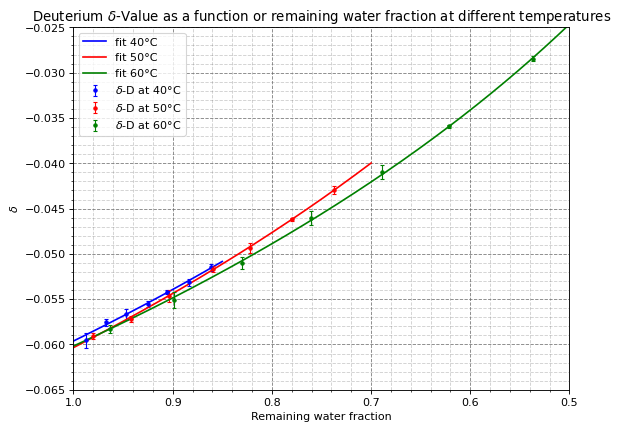

In [18]:
# Plot the delta 2H Values for all temperatures
popt_w40_2H, pcov_w40_2H = curve_fit(rayleigh, m_W_40, water_40_delta_2H * 10**(-3), sigma = water_40_delta_2H_sd * 10**(-3))
x_w40_2H = np.linspace(0.85, 1, 1000)

popt_w50_2H, pcov_w50_2H = curve_fit(rayleigh, m_W_50, water_50_delta_2H * 10**(-3), sigma = water_50_delta_2H_sd * 10**(-3))
x_w50_2H = np.linspace(0.7, 1, 1000)

popt_w60_2H, pcov_w60_2H = curve_fit(rayleigh, m_W_60, water_60_delta_2H * 10**(-3), sigma = water_60_delta_2H_sd * 10**(-3))
x_w60_2H = np.linspace(0.5, 1, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(m_W_40,water_40_delta_2H * 10**(-3), yerr = water_40_delta_2H_sd * 10**(-3), linestyle='None', marker = ".", color = "blue", label="$\delta$-D at 40°C", capsize = 2, elinewidth=1)
plt.plot(x_w40_2H, rayleigh(x_w40_2H, *popt_w40_2H), label="fit 40°C", color = "blue")
plt.errorbar(m_W_50,water_50_delta_2H * 10**(-3), yerr = water_50_delta_2H_sd * 10**(-3), linestyle='None', marker = ".", color = "red", label="$\delta$-D at 50°C", capsize = 2, elinewidth=1)
plt.plot(x_w50_2H, rayleigh(x_w50_2H, *popt_w50_2H), label="fit 50°C", color = "red")
plt.errorbar(m_W_60,water_60_delta_2H * 10**(-3), yerr = water_60_delta_2H_sd * 10**(-3), linestyle='None', marker = ".", color = "green", label="$\delta$-D at 60°C", capsize = 2, elinewidth=1)
plt.plot(x_w60_2H, rayleigh(x_w60_2H, *popt_w60_2H), label="fit 60°C", color = "green")
plt.xlabel('Remaining water fraction')
plt.ylabel('$\delta$')
plt.title('Deuterium $\delta$-Value as a function or remaining water fraction at different temperatures')
#plt.yscale('log')
plt.axis([1, 0.5, -0.065, -0.025])
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

print("Frac Factor 2H:", popt_w40_2H[0], "+-", np.sqrt(pcov_w40_2H[0,0]))
print("Frac Factor:", popt_w50_2H[0], "+-", np.sqrt(pcov_w50_2H[0,0]))
print("Frac Factor 2H:", popt_w60_2H[0], "+-", np.sqrt(pcov_w60_2H[0,0]))

Frac Factor 40°C: 0.9861885182441825 +- 0.0021190656357157256
Frac Factor 50°C: 0.9818453570304363 +- 0.00011955841318854921
Frac Factor 60°C: 0.9839469738180193 +- 0.0004981937851346043


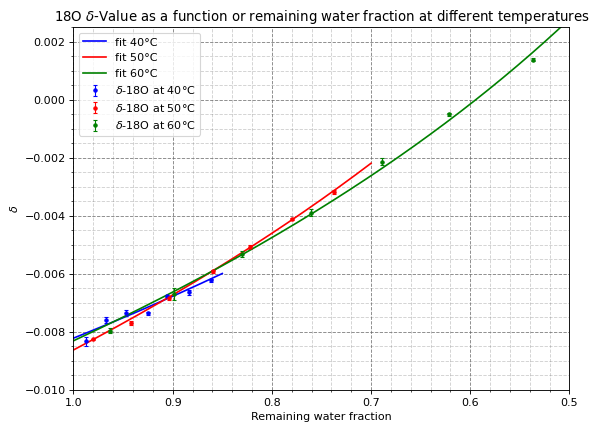

In [19]:
popt_w40_18O, pcov_w40_18O = curve_fit(rayleigh, m_W_40, water_40_delta_18O * 10**(-3), sigma = water_40_delta_18O_sd * 10**(-3))
x_w40_18O = np.linspace(0.85, 1, 1000)

popt_w50_18O, pcov_w50_18O = curve_fit(rayleigh, m_W_50, water_50_delta_18O * 10**(-3), sigma = water_50_delta_18O_sd * 10**(-3))
x_w50_18O = np.linspace(0.7, 1, 1000)

popt_w60_18O, pcov_w60_18O = curve_fit(rayleigh, m_W_60, water_60_delta_18O * 10**(-3), sigma = water_60_delta_18O_sd * 10**(-3))
x_w60_18O = np.linspace(0.5, 1, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(m_W_40,water_40_delta_18O * 10**(-3), yerr = water_40_delta_18O_sd * 10**(-3), linestyle='None', marker = ".", color = "blue", label="$\delta$-18O at 40°C", capsize = 2, elinewidth=1)
plt.plot(x_w40_18O, rayleigh(x_w40_18O, *popt_w40_18O), label="fit 40°C", color = "blue")
plt.errorbar(m_W_50,water_50_delta_18O * 10**(-3), yerr = water_50_delta_18O_sd * 10**(-3), linestyle='None', marker = ".", color = "red", label="$\delta$-18O at 50°C", capsize = 2, elinewidth=1)
plt.plot(x_w50_18O, rayleigh(x_w50_18O, *popt_w50_18O), label="fit 50°C", color = "red")
plt.errorbar(m_W_60,water_60_delta_18O * 10**(-3), yerr = water_60_delta_18O_sd * 10**(-3), linestyle='None', marker = ".", color = "green", label="$\delta$-18O at 60°C", capsize = 2, elinewidth=1)
plt.plot(x_w60_18O, rayleigh(x_w60_18O, *popt_w60_18O), label="fit 60°C", color = "green")
plt.xlabel('Remaining water fraction')
plt.ylabel('$\delta$')
plt.title('18O $\delta$-Value as a function or remaining water fraction at different temperatures')
#plt.yscale('log')
plt.axis([1, 0.5, -0.010, 0.0025])
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

print("Frac Factor 40°C:", popt_w40_18O[0], "+-", np.sqrt(pcov_w40_18O[0,0]))
print("Frac Factor 50°C:", popt_w50_18O[0], "+-", np.sqrt(pcov_w50_18O[0,0]))
print("Frac Factor 60°C:", popt_w60_18O[0], "+-", np.sqrt(pcov_w60_18O[0,0]))

Frac Factor 40°C: 0.9917728944882523 +- 0.0011019402091731873
Frac Factor 50°C: 0.990601016575072 +- 0.0002461707332265111
Frac Factor 60°C: 0.9922708140310372 +- 0.0006658038886227538


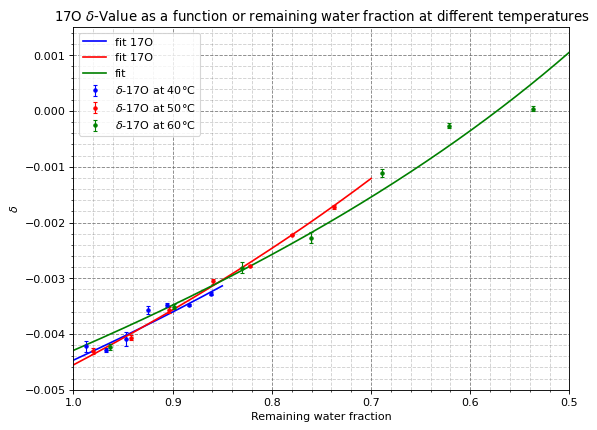

In [20]:
popt_w40_17O, pcov_w40_17O = curve_fit(rayleigh, m_W_40, water_40_delta_17O * 10**(-3), sigma = water_40_delta_17O_sd * 10**(-3))
x_w40_17O = np.linspace(0.85, 1, 1000)

popt_w50_17O, pcov_w50_17O = curve_fit(rayleigh, m_W_50, water_50_delta_17O * 10**(-3), sigma = water_50_delta_17O_sd * 10**(-3))
x_w50_17O = np.linspace(0.7, 1, 1000)

popt_w60_17O, pcov_w60_17O = curve_fit(rayleigh, m_W_60, water_60_delta_17O * 10**(-3), sigma = water_60_delta_17O_sd * 10**(-3))
x_w60_17O = np.linspace(0.5, 1, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(m_W_40,water_40_delta_17O * 10**(-3), yerr = water_40_delta_17O_sd * 10**(-3), linestyle='None', marker = ".", color = "blue", label="$\delta$-17O at 40°C", capsize = 2, elinewidth=1)
plt.plot(x_w40_17O, rayleigh(x_w40_17O, *popt_w40_17O), label="fit 17O", color = "blue")
plt.errorbar(m_W_50,water_50_delta_17O * 10**(-3), yerr = water_50_delta_17O_sd * 10**(-3), linestyle='None', marker = ".", color = "red", label="$\delta$-17O at 50°C", capsize = 2, elinewidth=1)
plt.plot(x_w50_17O, rayleigh(x_w50_17O, *popt_w50_17O), label="fit 17O", color = "red")
plt.errorbar(m_W_60,water_60_delta_17O * 10**(-3), yerr = water_60_delta_17O_sd * 10**(-3), linestyle='None', marker = ".", color = "green", label="$\delta$-17O at 60°C", capsize = 2, elinewidth=1)
plt.plot(x_w60_17O, rayleigh(x_w60_17O, *popt_w60_17O), label="fit", color = "green")
plt.xlabel('Remaining water fraction')
plt.ylabel('$\delta$')
plt.title('17O $\delta$-Value as a function or remaining water fraction at different temperatures')
#plt.yscale('log')
plt.axis([1, 0.5, -0.005, 0.0015])
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

print("Frac Factor 40°C:", popt_w40_17O[0], "+-", np.sqrt(pcov_w40_17O[0,0]))
print("Frac Factor 50°C:", popt_w50_17O[0], "+-", np.sqrt(pcov_w50_17O[0,0]))
print("Frac Factor 60°C:", popt_w60_17O[0], "+-", np.sqrt(pcov_w60_17O[0,0]))

#### Analysis of the delta-value courses
For all temperatures we can see the water getting heavier with time, after more and more of the water has evaporated, which is just as expected. For lower temperatures, the graph seems almost linear, while especially for 60°C the exponential nature of the function can be observed. The reason is that while the graphs follow the rayleigh fractionation equation for all temperatures, it only becomes very obvious for higher temperatures, since more of the water evaporated in the measured time frame.

In [21]:
# Water lines:
def linear(x, a, b):
    return a*x + b

# Join all data together, for all temperatures
water_all_delta_2H = np.concatenate((water_40_delta_2H, water_50_delta_2H, water_60_delta_2H))
water_all_delta_2H_sd = np.concatenate((water_40_delta_2H_sd, water_50_delta_2H_sd, water_60_delta_2H_sd))
water_all_delta_18O = np.concatenate((water_40_delta_18O, water_50_delta_18O, water_60_delta_18O))
water_all_delta_18O_sd = np.concatenate((water_40_delta_18O_sd, water_50_delta_18O_sd, water_60_delta_18O_sd))

Water Line slope:  3.0435349865313963 +- 0.04436623816121609
Water Line y-intercept:  -33.69311499925415 +- 0.24133032793298612
Deviation slope:  111.71704473699164
Deviation y-intercept:  181.05107374398085


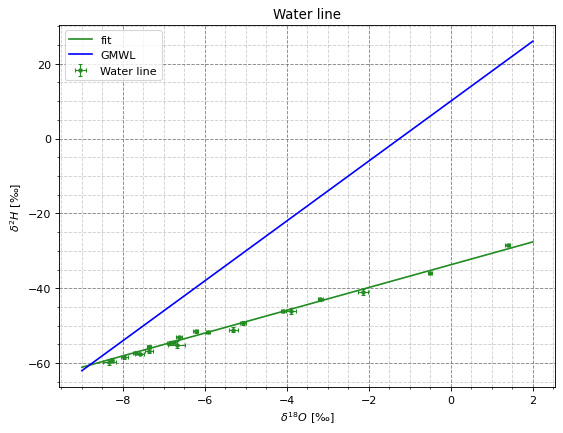

In [22]:
# Plot the water line and fit a linear function
popt_wlall, pcov_wlall = curve_fit(linear, water_all_delta_18O, water_all_delta_2H, sigma = water_all_delta_2H_sd)
x_wlall = np.linspace(-9, 2, 1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(water_all_delta_18O, water_all_delta_2H, xerr = water_all_delta_18O_sd, yerr = water_all_delta_2H_sd, linestyle='None', marker = ".", label="Water line", capsize = 2, elinewidth=1, color="forestgreen")
plt.plot(x_wlall, linear(x_wlall, *popt_wlall), label="fit", color="forestgreen")
plt.plot(x_wlall, linear(x_wlall, 8, 10), label = "GMWL", color="blue")
plt.xlabel('$\delta^{18}O$ [‰]')
plt.ylabel('$\delta^{2}H$ [‰]')
plt.title('Water line')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

# Deviation from water line slope
wl_slope_lit = 8
wl_yint_lit = 10
sigma_wlall = np.abs((wl_slope_lit - popt_wlall[0])/np.sqrt(pcov_wlall[0,0]))
sigma_yint_wlall = np.abs((wl_yint_lit - popt_wlall[1])/np.sqrt(pcov_wlall[1,1]))

print("Water Line slope: ", popt_wlall[0], "+-", np.sqrt(pcov_wlall[0,0]))
print("Water Line y-intercept: ", popt_wlall[1], "+-", np.sqrt(pcov_wlall[1,1]))
print("Deviation slope: ", sigma_wlall)
print("Deviation y-intercept: ", sigma_yint_wlall)

#### Analysis of the water line
We can see that our water line has a slope of around 3, while the GMWL has a slope of 8. The reason is that while the GWML considers only equilibrium isotope fractionation, while our process of water evaporating is a mixture of both kinetic isotope fractionation and equilibrium isotope fractionation, since the water containers were not closed and allowed water vapor to escape the container.

In [23]:
# Plotting the alpha factors
temp = np.array([40, 50, 60])
alpha_delta_2H = np.array([popt_w40_2H[0], popt_w50_2H[0], popt_w60_2H[0]])
alpha_delta_2H_sd = np.sqrt( np.array([pcov_w40_2H[0,0], pcov_w50_2H[0,0], pcov_w60_2H[0,0]]) )
alpha_delta_18O = np.array([popt_w40_18O[0], popt_w50_18O[0], popt_w60_18O[0]])
alpha_delta_18O_sd = np.sqrt( np.array([pcov_w40_18O[0,0], pcov_w50_18O[0,0], pcov_w60_18O[0,0]]) )
alpha_delta_17O = np.array([popt_w40_17O[0], popt_w50_17O[0], popt_w60_17O[0]])
alpha_delta_17O_sd = np.sqrt( np.array([pcov_w40_17O[0,0], pcov_w50_17O[0,0], pcov_w60_17O[0,0]]) )

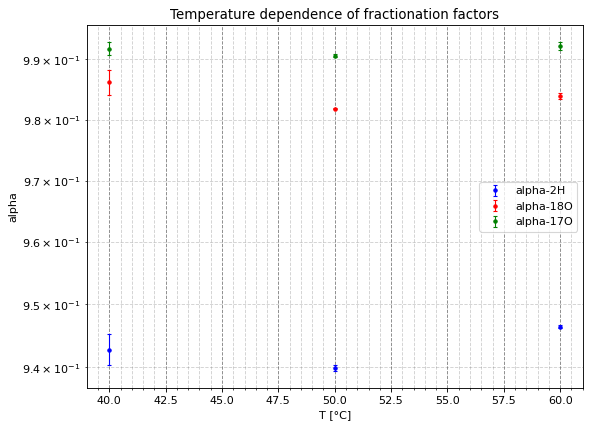

In [24]:
plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(temp, alpha_delta_2H, yerr = alpha_delta_2H_sd, linestyle='None', marker = ".", label="alpha-2H", capsize = 2, elinewidth=1, color="blue")
plt.errorbar(temp, alpha_delta_18O, yerr = alpha_delta_18O_sd, linestyle='None', marker = ".", label="alpha-18O", capsize = 2, elinewidth=1, color="red")
plt.errorbar(temp, alpha_delta_17O, yerr = alpha_delta_17O_sd, linestyle='None', marker = ".", label="alpha-17O", capsize = 2, elinewidth=1, color="green")
plt.ylabel('alpha')
plt.xlabel('T [°C]')
plt.title('Temperature dependence of fractionation factors')
plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

#### Analysis of the fractionation factors
We can observe that the fractionation factors are approximately constant for all temperatures and for all three isotopes.

- Should get closer to 1 with rising temperature
- Not clearly visible because small effect
- more clearly with 2H because mass fraction is double

# 6.4 Finding the source of unknown samples

In [25]:
# Once again print the final measured values:


for i in range(unknown_samples_list.size):
    print(unknown_samples_list[i], ":")
    print("d2H = ", unknown_samples_delta_2H[i], "+-", unknown_samples_delta_2H_sd[i])
    print("d18O = ", unknown_samples_delta_18O[i], "+-", unknown_samples_delta_18O_sd[i])
    print("d17O = ", unknown_samples_delta_17O[i], "+-", unknown_samples_delta_17O_sd[i])

W017 :
d2H =  -67.341215 +- 0.44376378023260304
d18O =  -9.7936065 +- 0.06323187243094122
d17O =  -5.1209415 +- 0.05018128071977688
W070 :
d2H =  -29.952336 +- 0.6395154
d18O =  -5.322863 +- 0.119458
d17O =  -2.659701 +- 0.02975414
W071 :
d2H =  -31.00985 +- 0.40947886874349204
d18O =  -5.5768015 +- 0.051025164580932515
d17O =  -2.8248485 +- 0.06205312973510765
K001 :
d2H =  -38.061883 +- 0.26001882000059634
d18O =  -6.8601035 +- 0.029549800117781258
d17O =  -3.47078 +- 0.04356654462328433
K007 :
d2H =  -41.6421785 +- 0.4182432619259903
d18O =  -4.734077 +- 0.05635897782102865
d17O =  -2.480701 +- 0.05061391757526407


#### Analysis: which samples could be which
Here, we are going to list a few locations that could be the origin of our water samples, and then select one origin which is the most likely. <br>
#### W017 
could be Puslinch (-67.484, -9.839, -5.231)
or could be Bad Liebenwerda (-66.746, -9.803, -5.159)
or could be Wiesenburg (-66.302, 9.467, -5.178) <br>
The most likely is Bad Liebenwerda
It is KOrunni CZR

#### W070 
could be Serra do Buaco (-27.959, -5.125, -2.7)
or could be Serra do Geras (-30.636, -5.456, -2.897)
or could be Serra de Sao Mamede (-31.654, -5.649, -3.032) <br>
Most likely is Serra do Gerês Correct :)

#### W071
very similar to W070, but no location is really 100% fitting. <br>
Most likely is also Serra do Gerês
It is Serra de Sao Mamede

#### K001 
could be Crete (-37.961, -7.193, -3.798)
or could be Julatten (-37.655, -6.393, -3.465)
or could be Dubrovnik (-39.59, -6.689, -3.701) <br>
The most likely is Julatten, Australia.
It is Taiwan Ji'an

#### K007 
could be Katzenbuckel (-41.715, -4.665, -2.506), which is also the most likely.
Correct :)

#### General trends:
futher from coast -> lighter, continental effect, has travelled longer distance
--> more of the heavier isotopes have been carried away by rain

higher altitude --> lighter, because colder

# 6.3 Local Rainwater Samples

In [26]:
# Reading the rainwater data from the .csv files
fileloc_rw_individual = os.path.join(dirname, 'Rainwater_Samples_Individual.csv')
fileloc_rw_means = os.path.join(dirname, 'Rainwater_Samples_Means.csv')

df_rw_individual = pd.read_csv(fileloc_rw_individual, delimiter=";", nrows=385, decimal=',')
df_rw_means = pd.read_csv(fileloc_rw_means, delimiter=";", nrows=70, decimal=',')

rw_individual_probe_id = df_rw_individual['Probennummer'].to_numpy()
rw_means_probe_id = df_rw_means["Sample Name"].to_numpy()

rw_individual_date_start = df_rw_individual["Von"].to_numpy()
rw_individual_date_end = df_rw_individual["Bis"].to_numpy()

rw_means_date_start = df_rw_means["von"].to_numpy()
rw_means_date_end = df_rw_means["bis"].to_numpy()

rw_individual_delta_2H = df_rw_individual["delta_D"].to_numpy().astype(np.float64)
rw_individual_delta_2H_sd = df_rw_individual["delta_D_stDev"].to_numpy().astype(np.float64)
rw_means_delta_2H = df_rw_means["Processed Delta 2H"].to_numpy().astype(np.float64)
rw_means_delta_2H_sd = df_rw_means["Processed Delta 2H StDev"].to_numpy().astype(np.float64)

rw_individual_delta_18O = df_rw_individual["delta_18O"].to_numpy().astype(np.float64)
rw_individual_delta_18O_sd = df_rw_individual["delta_18O_stDev"].to_numpy().astype(np.float64)
rw_means_delta_18O = df_rw_means["Processed Delta 18O"].to_numpy().astype(np.float64)
rw_means_delta_18O_sd = df_rw_means["Processed Delta 18O StDev"].to_numpy().astype(np.float64)

rw_individual_delta_17O = df_rw_individual["delta_17O"].to_numpy().astype(np.float64)
rw_individual_delta_17O_sd = df_rw_individual["delta_17O_stDev"].to_numpy().astype(np.float64)
rw_means_delta_17O = df_rw_means["Processed Delta 17O"].to_numpy().astype(np.float64)
rw_means_delta_17O_sd = df_rw_means["Processed Delta 17O StDev"].to_numpy().astype(np.float64)

# Rainwater samples timeframes:
# 641: 18.-21.11.2022
# 603: 29.4. - 3.5.2022
# 105: 4.10. - 2.11.2022
# 102: 29.6. - 2.8.2022

for i in range(rainwater_samples_list.size):
    print(rainwater_samples_list[i], ":")
    print("d2H = ", rainwater_samples_delta_2H[i], "+-", rainwater_samples_delta_2H_sd[i])
    print("d18O = ", rainwater_samples_delta_18O[i], "+-", rainwater_samples_delta_18O_sd[i])
    print("d17O = ", rainwater_samples_delta_17O[i], "+-", rainwater_samples_delta_17O_sd[i])

603 :
d2H =  -34.908656 +- 0.6063177
d18O =  -6.126761 +- 0.04405666
d17O =  -3.455611 +- 0.05764392
641 :
d2H =  -64.871163 +- 0.116136
d18O =  -9.956885 +- 0.06547036
d17O =  -4.930588 +- 0.05465004
102 :
d2H =  -22.150757 +- 0.510213
d18O =  -3.951111 +- 0.05218687
d17O =  -2.670707 +- 0.04835266
105 :
d2H =  -31.2348875 +- 0.3782976374263425
d18O =  -5.487845999999999 +- 0.04109958953594366
d17O =  -3.1383210000000004 +- 0.05468136656626003


In [39]:
# convert dates into time

def convert_to_time(date):
    date_split = date.split(".")
    day = date_split[0]
    month = date_split[1]
    year = date_split[2]
    time = 365 * int(year) + 30.4 * int(month) + int(day)
    return time

rw_individual_x = []
rw_means_x = []

for i in range(rw_individual_date_start.size):
    rw_individual_x.append( (convert_to_time(rw_individual_date_start[i]) + convert_to_time(rw_individual_date_end[i])) / 2 )
    
for i in range(rw_means_date_start.size):
    rw_means_x.append((convert_to_time(rw_means_date_start[i]) + convert_to_time(rw_means_date_end[i])) / 2)
    
# now append our measured values to the data
#rw_individual_x.append(convert_to_time('1.5.2022'))
#rw_individual_x.append(convert_to_time('20.11.2022'))

#rw_individual_delta_2H_final = np.append(rw_individual_delta_2H, [rainwater_samples_delta_2H[0], rainwater_samples_delta_2H[1]])
#rw_individual_delta_18O_final = np.append(rw_individual_delta_18O, [rainwater_samples_delta_18O[0], rainwater_samples_delta_18O[1]])
#rw_individual_delta_17O_final = np.append(rw_individual_delta_17O, [rainwater_samples_delta_17O[0], rainwater_samples_delta_17O[1]])
#rw_individual_delta_2H_sd_final = np.append(rw_individual_delta_2H_sd, [rainwater_samples_delta_2H_sd[0], rainwater_samples_delta_2H_sd[1]])
#rw_individual_delta_18O_sd_final = np.append(rw_individual_delta_18O_sd, [rainwater_samples_delta_18O_sd[0], rainwater_samples_delta_18O_sd[1]])
#rw_individual_delta_17O_sd_final = np.append(rw_individual_delta_17O_sd, [rainwater_samples_delta_17O_sd[0], rainwater_samples_delta_17O_sd[1]])

#rw_means_x.append(convert_to_time('16.7.2022'))
#rw_means_x.append(convert_to_time('16.10.2022'))

#rw_means_delta_2H_final = np.append(rw_means_delta_2H, [rainwater_samples_delta_2H[2], rainwater_samples_delta_2H[3]])
#rw_means_delta_18O_final = np.append(rw_means_delta_18O, [rainwater_samples_delta_18O[2], rainwater_samples_delta_18O[3]])
#rw_means_delta_17O_final = np.append(rw_means_delta_17O, [rainwater_samples_delta_17O[2], rainwater_samples_delta_17O[3]])
#rw_means_delta_2H_sd_final = np.append(rw_means_delta_2H_sd, [rainwater_samples_delta_2H_sd[2], rainwater_samples_delta_2H_sd[3]])
#rw_means_delta_18O_sd_final = np.append(rw_means_delta_18O_sd, [rainwater_samples_delta_18O_sd[2], rainwater_samples_delta_18O_sd[3]])
#rw_means_delta_17O_sd_final = np.append(rw_means_delta_17O_sd, [rainwater_samples_delta_17O_sd[2], rainwater_samples_delta_17O_sd[3]])

# plot our own data seperately in a different color
rw_individual_own_x = np.array([convert_to_time("1.5.2022"), convert_to_time("20.11.2022")])
rw_individual_delta_2H_own = np.array([rainwater_samples_delta_2H[0], rainwater_samples_delta_2H[1]])
rw_individual_delta_2H_sd_own = np.array([rainwater_samples_delta_2H_sd[0], rainwater_samples_delta_2H_sd[1]])
rw_individual_delta_18O_own = np.array([rainwater_samples_delta_18O[0], rainwater_samples_delta_18O[1]])
rw_individual_delta_18O_sd_own = np.array([rainwater_samples_delta_18O_sd[0], rainwater_samples_delta_18O_sd[1]])
rw_individual_delta_17O_own = np.array([rainwater_samples_delta_17O[0], rainwater_samples_delta_17O[1]])
rw_individual_delta_17O_sd_own = np.array([rainwater_samples_delta_17O_sd[0], rainwater_samples_delta_17O_sd[1]])

rw_means_own_x = np.array([convert_to_time("16.7.2022"), convert_to_time("16.10.2022")])
rw_means_delta_2H_own = np.array([rainwater_samples_delta_2H[2], rainwater_samples_delta_2H[3]])
rw_means_delta_2H_sd_own = np.array([rainwater_samples_delta_2H_sd[2], rainwater_samples_delta_2H_sd[3]])
rw_means_delta_18O_own = np.array([rainwater_samples_delta_18O[2], rainwater_samples_delta_18O[3]])
rw_means_delta_18O_sd_own = np.array([rainwater_samples_delta_18O_sd[2], rainwater_samples_delta_18O_sd[3]])
rw_means_delta_17O_own = np.array([rainwater_samples_delta_17O[2], rainwater_samples_delta_17O[3]])
rw_means_delta_17O_sd_own = np.array([rainwater_samples_delta_17O_sd[2], rainwater_samples_delta_17O_sd[3]])

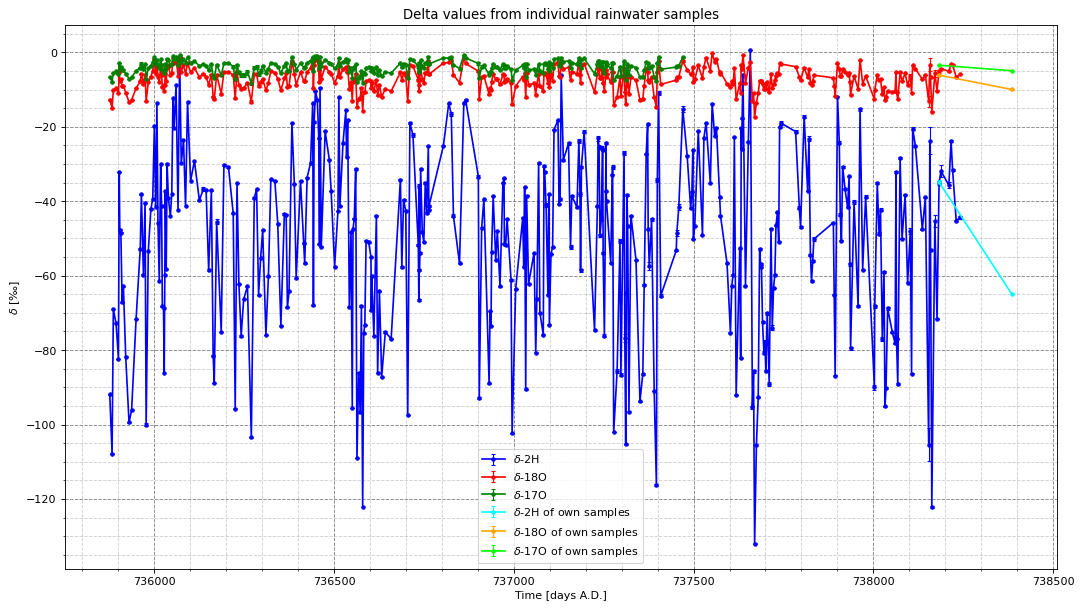

In [41]:
# Now plot our delta values
# beginning with the individual measurements
plt.figure(figsize=(16, 9), dpi=80)
#plt.errorbar(rw_individual_x, rw_individual_delta_2H_final, yerr = rw_individual_delta_2H_sd_final, marker = ".", label="$\delta$-2H", capsize = 2, elinewidth=1, color="blue")
#plt.errorbar(rw_individual_x, rw_individual_delta_18O_final, yerr = rw_individual_delta_18O_sd_final, marker = ".", label="$\delta$-18O", capsize = 2, elinewidth=1, color="red")
#plt.errorbar(rw_individual_x, rw_individual_delta_17O_final, yerr = rw_individual_delta_17O_sd_final, marker = ".", label="$\delta$-17O", capsize = 2, elinewidth=1, color="green")
plt.errorbar(rw_individual_x, rw_individual_delta_2H, yerr = rw_individual_delta_2H_sd, marker = ".", label="$\delta$-2H", capsize = 2, elinewidth=1, color="blue")
plt.errorbar(rw_individual_x, rw_individual_delta_18O, yerr = rw_individual_delta_18O_sd, marker = ".", label="$\delta$-18O", capsize = 2, elinewidth=1, color="red")
plt.errorbar(rw_individual_x, rw_individual_delta_17O, yerr = rw_individual_delta_17O_sd, marker = ".", label="$\delta$-17O", capsize = 2, elinewidth=1, color="green")
plt.errorbar(rw_individual_own_x, rw_individual_delta_2H_own, yerr = rw_individual_delta_2H_sd_own, marker = ".", label="$\delta$-2H of own samples", capsize = 2, elinewidth = 1, color="cyan")
plt.errorbar(rw_individual_own_x, rw_individual_delta_18O_own, yerr = rw_individual_delta_18O_sd_own, marker = ".", label="$\delta$-18O of own samples", capsize = 2, elinewidth = 1, color="orange")
plt.errorbar(rw_individual_own_x, rw_individual_delta_17O_own, yerr = rw_individual_delta_17O_sd_own, marker = ".", label="$\delta$-17O of own samples", capsize = 2, elinewidth = 1, color="lime")
plt.xlabel('Time [days A.D.]')
plt.ylabel('$\delta$ [‰]')
plt.title('Delta values from individual rainwater samples')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

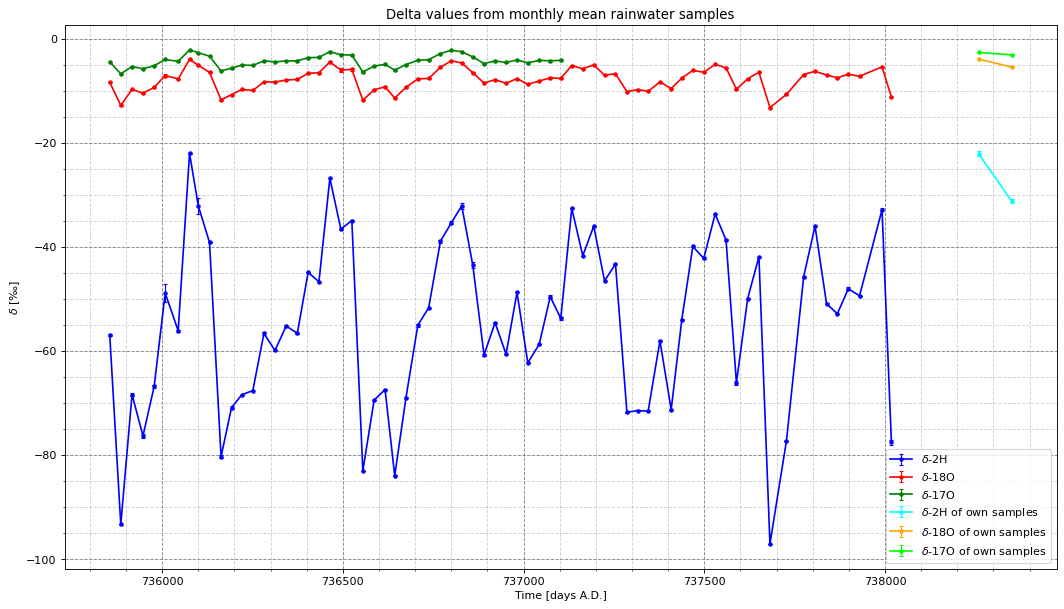

In [42]:
plt.figure(figsize=(16, 9), dpi=80)
#plt.errorbar(rw_means_x, rw_means_delta_2H_final, yerr = rw_means_delta_2H_sd_final, marker = ".", label="$\delta$-2H", capsize = 2, elinewidth=1, color="blue")
#plt.errorbar(rw_means_x, rw_means_delta_18O_final, yerr = rw_means_delta_18O_sd_final, marker = ".", label="$\delta$-18O", capsize = 2, elinewidth=1, color="red")
#plt.errorbar(rw_means_x, rw_means_delta_17O_final, yerr = rw_means_delta_17O_sd_final, marker = ".", label="$\delta$-17O", capsize = 2, elinewidth=1, color="green")
plt.errorbar(rw_means_x, rw_means_delta_2H, yerr = rw_means_delta_2H_sd, marker = ".", label="$\delta$-2H", capsize = 2, elinewidth=1, color="blue")
plt.errorbar(rw_means_x, rw_means_delta_18O, yerr = rw_means_delta_18O_sd, marker = ".", label="$\delta$-18O", capsize = 2, elinewidth=1, color="red")
plt.errorbar(rw_means_x, rw_means_delta_17O, yerr = rw_means_delta_17O_sd, marker = ".", label="$\delta$-17O", capsize = 2, elinewidth=1, color="green")
plt.errorbar(rw_means_own_x, rw_means_delta_2H_own, yerr = rw_means_delta_2H_sd_own, marker = ".", label="$\delta$-2H of own samples", capsize = 2, elinewidth = 1, color="cyan")
plt.errorbar(rw_means_own_x, rw_means_delta_18O_own, yerr = rw_means_delta_18O_sd_own, marker = ".", label="$\delta$-18O of own samples", capsize = 2, elinewidth = 1, color="orange")
plt.errorbar(rw_means_own_x, rw_means_delta_17O_own, yerr = rw_means_delta_17O_sd_own, marker = ".", label="$\delta$-17O of own samples", capsize = 2, elinewidth = 1, color="lime")
plt.xlabel('Time [days A.D.]')
plt.ylabel('$\delta$ [‰]')
plt.title('Delta values from monthly mean rainwater samples')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

#### Analysis of the rainwater delta values:
In both distributions the seasonal effects are clearly visible, with the delta values achieving peaks and lows periodically. The general mean seems to be constant.

In [30]:
# LMWL:
rw_lmwl_delta_2H = np.append(rw_individual_delta_2H_final, rw_means_delta_2H_final)
rw_lmwl_delta_2H_sd = np.append(rw_individual_delta_2H_sd_final, rw_means_delta_2H_sd_final)

# we have a problem with the error of delta 2H being zero, so we replace the zeros with very small values instead
for i in range(rw_lmwl_delta_2H_sd.size):
    if (rw_lmwl_delta_2H_sd[i] == 0):
        rw_lmwl_delta_2H_sd[i] = 0.0001 * rw_lmwl_delta_2H[i]
        print("Replaced a zero!")

rw_lmwl_delta_18O = np.append(rw_individual_delta_18O_final, rw_means_delta_18O_final)
rw_lmwl_delta_18O_sd = np.append(rw_individual_delta_18O_sd_final, rw_means_delta_18O_sd_final)

Replaced a zero!


Slope LMWL: 7.7893658747274275 +- 0.07643303287882162
Deviation slope:  2.7557996502181963
y-int LMWL: 5.801519355359952 +- 0.6015527399489599
Deviation yint: 6.979405737552252


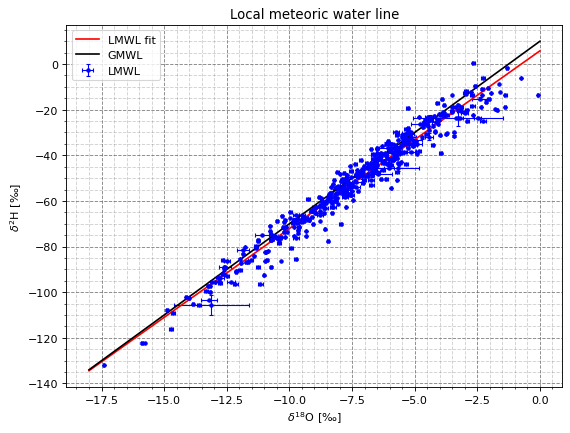

In [43]:
popt_lmwl, pcov_lmwl = curve_fit(linear, rw_lmwl_delta_18O, rw_lmwl_delta_2H)#sigma = rw_lmwl_delta_2H_sd
x_lmwl = np.linspace(-18,0,1000)

plt.figure(figsize=(8, 6), dpi=80)
plt.errorbar(rw_lmwl_delta_18O, rw_lmwl_delta_2H, xerr = rw_lmwl_delta_18O_sd, yerr = rw_lmwl_delta_2H_sd, linestyle="none", marker = ".", label="LMWL", capsize = 2, elinewidth=1, color="blue")
plt.plot(x_lmwl, linear(x_lmwl, *popt_lmwl), label="LMWL fit", color="red")
plt.plot(x_lmwl, linear(x_lmwl, 8, 10), label = "GMWL", color="black")
plt.xlabel('$\delta^{18}$O [‰]')
plt.ylabel('$\delta^{2}$H [‰]')
plt.title('Local meteoric water line')
#plt.yscale('log')
plt.legend()
plt.grid(b=True, which='major', color='#666666', linestyle='--', alpha = 0.8)
plt.grid(b=True, which='minor', color='#666666', linestyle='--', alpha = 0.3)
plt.minorticks_on()

# Calculate the deviation from the GMWL
print("Slope LMWL:", popt_lmwl[0], "+-", np.sqrt(pcov_lmwl[0,0]))
sigma_lmwl = (8 - popt_lmwl[0])/np.sqrt(pcov_lmwl[0,0])
print("Deviation slope: ", sigma_lmwl)
print("y-int LMWL:", popt_lmwl[1], "+-", np.sqrt(pcov_lmwl[1,1]))
sigma_lmwl_yint = (10 - popt_lmwl[1])/np.sqrt(pcov_lmwl[1,1])
print("Deviation yint:", sigma_lmwl_yint)

#### LMWL analysis
The LMWL from the rainwater samples as well as our measured samples is in agreement with the GMWL values, with a deviation of 2,8 sigma. The deviation would be even lower if the fit would have converged while considering y errors, and if it could consider x errors. So eventhough our fit did not consider datapoint errors at all, the deviation is still not significant.